In [2]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm

from utils import get_dls, evaluate

In [3]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

# tensorflow RNG
# tf.random.set_seed(seed)

In [4]:
path = Path("/mnt/nas/backups/08-07-2020/desktopg01/lisa/Data/small_flow")

In [5]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=GrandparentSplitter(valid_name="val"),
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.9,
                                               do_flip=False, max_rotate=0,
                                               max_warp=0
                                               ),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [6]:
dls = get_dls(64, 224)

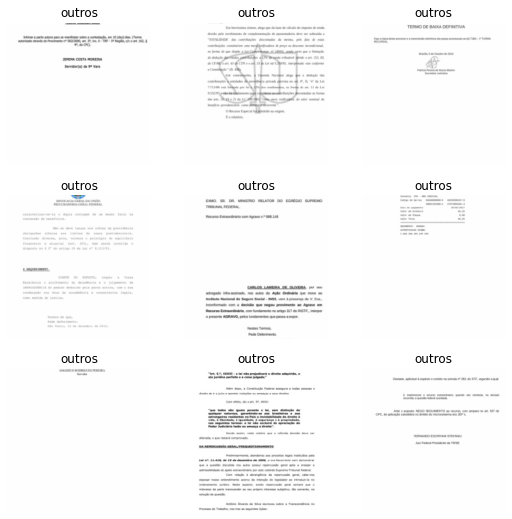

In [7]:
dls.show_batch()

In [8]:
fscore = F1Score(average='macro')

In [36]:
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, fscore])

In [37]:
learn.freeze()

In [ ]:
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    4,096      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     False     
_________________________________________________

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.02754228748381138)

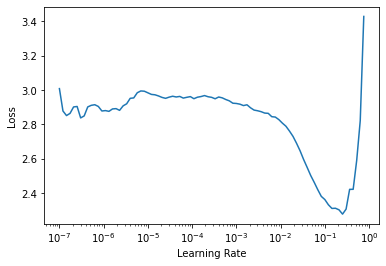

In [ ]:
learn.lr_find()

In [38]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.359715,0.381669,0.888608,0.180292,3:03:31


In [39]:
learn.unfreeze()
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    4,096      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     True      
_________________________________________________

SuggestedLRs(lr_min=5.248074739938602e-06, lr_steep=5.754399353463668e-06)

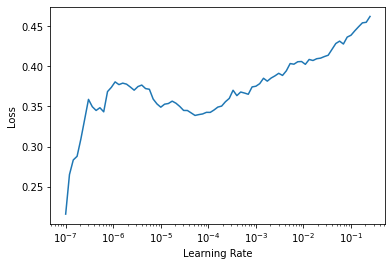

In [ ]:
learn.lr_find()

In [40]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_image_weights_224'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.362220,0.379039,0.889405,0.198338,3:06:23
1,0.342623,0.378291,0.894579,0.249932,2:59:42
2,0.355471,0.352191,0.897492,0.276472,2:58:03
3,0.317909,0.397183,0.902386,0.299169,2:56:30
4,0.328275,0.369864,0.898735,0.279513,2:56:27
5,0.306080,0.358469,0.900483,0.279228,2:56:26


Better model found at epoch 0 with f1_score value: 0.1983376482559104.


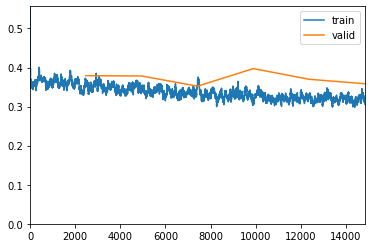

Better model found at epoch 1 with f1_score value: 0.24993180297544645.
Better model found at epoch 2 with f1_score value: 0.27647240516667315.
Better model found at epoch 3 with f1_score value: 0.2991690569867258.


In [41]:
learn.fit_one_cycle(6, lr_max=slice(2e-6,2e-5))

In [42]:
learn.load("best_image_weights_224")

In [43]:
from sklearn.metrics import classification_report
preds, targets = learn.get_preds()
preds = np.argmax(preds, axis=1)
print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.6667    0.0127    0.0250       314
agravo_em_recurso_extraordinario     0.0000    0.0000    0.0000      2650
     despacho_de_admissibilidade     0.0000    0.0000    0.0000       183
                          outros     0.9047    0.9950    0.9477     91434
                   peticao_do_RE     0.7808    0.2095    0.3303      6803
                        sentenca     0.9373    0.3335    0.4920      1613

                        accuracy                         0.9024    102997
                       macro avg     0.5482    0.2585    0.2992    102997
                    weighted avg     0.8714    0.9024    0.8709    102997



In [17]:
n_samples = len(dls.train_ds); n_samples

158308

In [18]:
class_counts = np.array([len((path/"train"/c).ls()) for c in dls.vocab]); class_counts

array([   583,   4220,    361, 140786,  10181,   2177])

In [19]:
class_weights = n_samples / (dls.c * class_counts); class_weights

array([45.25671812,  6.25229068, 73.0877193 ,  0.18740973,  2.59155944,
       12.11973664])

In [20]:
class_weights = torch.FloatTensor(class_weights).cuda()

In [21]:
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(weight=class_weights), metrics=[accuracy, fscore])

In [22]:
learn.freeze()

In [23]:
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    4,096      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     False     
_________________________________________________

SuggestedLRs(lr_min=2.7542287716642023e-05, lr_steep=6.309573450380412e-07)

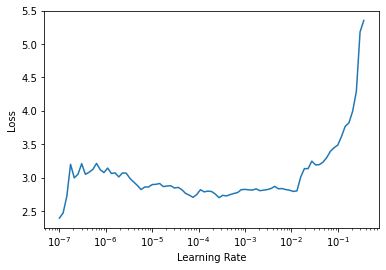

In [24]:
learn.lr_find()

In [25]:
learn.fit_one_cycle(1, 2e-4)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.360886,1.454434,0.401089,0.229758,3:09:04


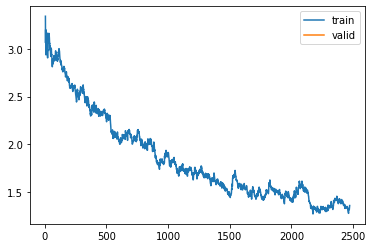

In [26]:
learn.recorder.plot_loss()

In [27]:
learn.unfreeze()
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    4,096      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     True      
_________________________________________________

SuggestedLRs(lr_min=3.311311302240938e-05, lr_steep=1.9054607491852948e-06)

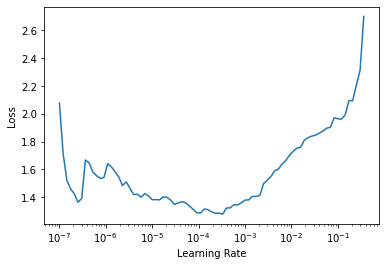

In [28]:
learn.lr_find()

In [29]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_image_no_weights_224'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.233662,1.429354,0.399788,0.229313,3:44:18
1,1.133132,1.358721,0.414866,0.261987,3:54:27
2,0.982449,1.288375,0.458188,0.270816,3:54:58
3,0.934707,1.187404,0.488490,0.282069,3:54:29
4,0.883219,1.186810,0.486946,0.292880,3:50:18
5,0.891511,1.193160,0.489577,0.291462,3:05:39


Better model found at epoch 0 with f1_score value: 0.22931253425496304.


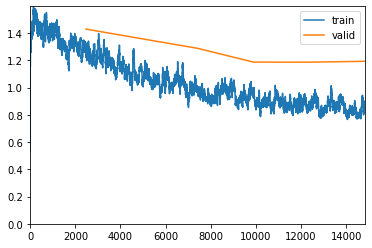

Better model found at epoch 1 with f1_score value: 0.2619866163330215.
Better model found at epoch 2 with f1_score value: 0.27081576071328567.
Better model found at epoch 3 with f1_score value: 0.2820685249123392.
Better model found at epoch 4 with f1_score value: 0.29288030895420103.


In [30]:
learn.fit_one_cycle(6, lr_max=slice(2e-6,2e-5))

In [31]:
learn.load("best_image_no_weights_224")

In [32]:
preds, targets = learn.get_preds()
preds = np.argmax(preds, axis=1)
print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0991    0.8185    0.1768       314
agravo_em_recurso_extraordinario     0.0627    0.7317    0.1156      2650
     despacho_de_admissibilidade     0.0399    0.6831    0.0753       183
                          outros     0.9827    0.4637    0.6301     91434
                   peticao_do_RE     0.2193    0.6265    0.3248      6803
                        sentenca     0.3099    0.7272    0.4346      1613

                        accuracy                         0.4869    102997
                       macro avg     0.2856    0.6751    0.2929    102997
                    weighted avg     0.8937    0.4869    0.5913    102997



In [ ]:
items = get_image_files(path); items

In [ ]:
test_items = g